# Анализ воронки продаж мобильного приложения. Анализ результатов А/А/В-эксперимента по внедрению новых шрифтов.

## Содержание:
* [Описание проекта.](#0)
* [1. Общая информация.](#1)
* [2. Предварительная подготовка данных.](#2)
* [3. Изучение и проверка данных.](#3)
* [4. Изучение воронки событий.](#4)
* [5. Анализ результатов эксперимента.](#5)
* [6. Выводы исследования.](#6)

## Описание проекта <a class="anchor" id="0"></a>

Цель исследования - проанализировать поведение пользователей мобильного приложения, изучив воронку продаж, обратив внимание на этапы, на которых могут застревать пользователи. А также изучить результаты проведенного А/А/В-эксперимента по внедрению новых шрифтов, выяснив, какой из них лучше.

## 1. Общая информация. <a class="anchor" id="1"></a>

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
from datetime import date
import scipy.stats as stats
from plotly import graph_objects as go
import math as mth

In [48]:
try:
    data = pd.read_csv('logs_exp.csv', sep='\t')
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/logs_exp.csv', sep='\t')

In [49]:
data.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


## 2. Предварительная подготовка данных.<a class="anchor" id="2"></a>

#### Замена названий столбцов.



In [50]:
data.rename(
    columns = {'EventName':'event',
               'DeviceIDHash':'user_id',
               'EventTimestamp':'timestamp',
               'ExpId':'group'}, inplace = True
)

#### Проверка на пропуски и соответсвие типов данных.

In [51]:
# проверяем на пропуски и смотрим типы данных методом .info()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   event      244126 non-null  object
 1   user_id    244126 non-null  int64 
 2   timestamp  244126 non-null  int64 
 3   group      244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [52]:
# проверяем на дубликаты
data.duplicated().sum()

413

In [53]:
# удаляем дубликаты
data.drop_duplicates(inplace=True)

In [54]:
data.duplicated().sum()

0

In [55]:
data['event'].unique()

array(['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear',
       'OffersScreenAppear', 'Tutorial'], dtype=object)

In [56]:
data['group'].unique()

array([246, 248, 247])

In [57]:
data.groupby('group').agg({'event':'count'})

,event
group,
246,80181
247,77950
248,85582


#### Добавление столбцов с датой, а также с датой и временем.

In [58]:
# добавляем столбец с датой и временем
data['datetime'] = pd.to_datetime(data['timestamp'], unit = 's')
# и отдельный столбец с датой
data['date'] = data['datetime'].dt.date

In [59]:
data.head()

,event,user_id,timestamp,group,datetime,date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25


## 3. Изучение и проверка данных.<a class="anchor" id="3"></a>

#### Сколько всего событий в логе.

In [60]:
len(data)

243713

#### Сколько всего пользователей в логе.

In [61]:
data['user_id'].nunique()

7551

#### Среднее количество событий на пользователя.

In [62]:
data.groupby('user_id').agg({'event':'count'})['event'].describe()

count    7551.000000
mean       32.275593
std        65.154219
min         1.000000
25%         9.000000
50%        20.000000
75%        37.000000
max      2307.000000
Name: event, dtype: float64

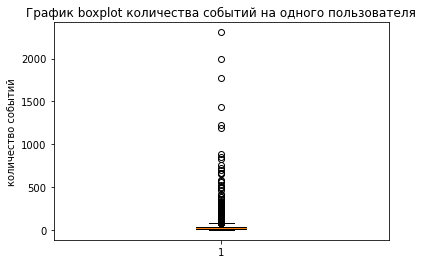

In [63]:
# посмотрим выбросы на графике boxplot
plt.boxplot(data.groupby('user_id').agg({'event':'count'})['event'])

plt.ylabel('количество событий')
plt.title('График boxplot количества событий на одного пользователя')

plt.show()

Среднее количество событий на пользователя - 32, медиана - 20. В данных есть выбросы c экстремальными значениями с сотнями и даже тысячами событий.

Text(0.5, 0, '')

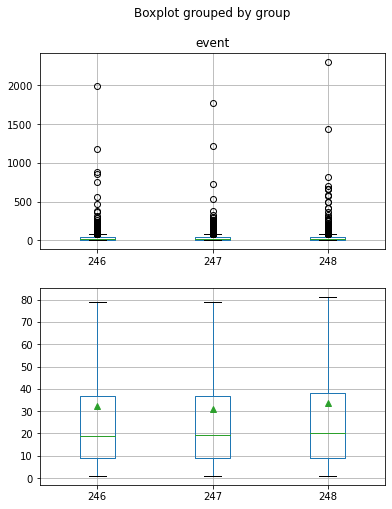

In [64]:
#CODE REVIEW
# И еще хорошо расммотреть в разрезе групп
event_cnts = data.groupby(['group', 'user_id'], as_index=False).agg({'event':'count'})

fig, axes = plt.subplots(nrows=2, figsize=(6, 8))
ax = axes[0]
event_cnts[['group', 'event']].boxplot(by='group', ax=ax)
ax.set_xlabel("")

ax = axes[1]
event_cnts[['group', 'event']].boxplot(by='group', showmeans=True, showfliers=False, ax=ax)
ax.set_title("")
ax.set_xlabel("")

#### Определение периода, за который есть данные. 
Максимальная и минимальная даты. Построение гистограммы по дате и времени. 

Можно ли быть уверенным, что в наличии одинаково полные данные за весь период? Технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого — это может «перекашивать данные». Необходимо определить, с какого момента данные полные и отбросить более старые. После этого определить реальный период, за который есть данные. 



In [65]:
data.agg({'date':['min','max']})

,date
min,2019-07-25
max,2019-08-07


In [66]:
data['date'].nunique()

14

Имеются данные за 14 дней. Минимальная дата - 25 июля 2019, максимальная - 7 августа 2019

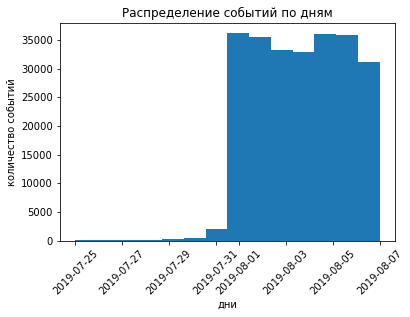

In [67]:
# построим диаграмму, показывающее распределение событий по дням
plt.hist(data['date'],bins = 14)
plt.ylabel('количество событий')
plt.xlabel('дни')
plt.title('Распределение событий по дням')

plt.xticks(rotation=45)
plt.show()

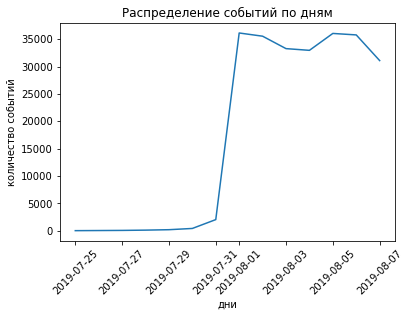

In [68]:

plt.plot(data.groupby('date').agg({'user_id':'count'}))
plt.ylabel('количество событий')
plt.xlabel('дни')
plt.title('Распределение событий по дням')

plt.xticks(rotation=45)
plt.show()



In [69]:
data.groupby('date').agg({'user_id':'count'}).reset_index()

,date,user_id
0,2019-07-25,9
1,2019-07-26,31
2,2019-07-27,55
3,2019-07-28,105
4,2019-07-29,184
5,2019-07-30,412
6,2019-07-31,2030
7,2019-08-01,36141
8,2019-08-02,35554
9,2019-08-03,33282


Начиная с 1 августа в день насчитывается не менее 31 000 событий, до этой даты количество событий не превышает 2030. Реальным периодом, за который имеются данные, явлется 01.08.19 - 07.08.19. Данные о событиях до 1 августа необходимо отбросить.

In [70]:
data_real = data[data['date']>dt.date(2019, 7, 31)]

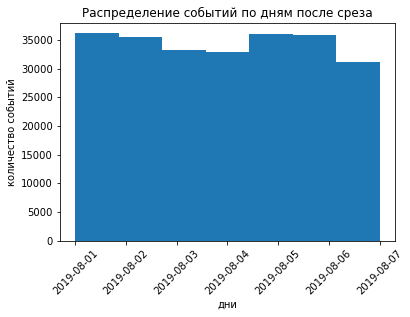

In [71]:
# построим новую диаграмму распределения заказов по дням после того, как отбросили данные до 1 августа
plt.hist(data_real['date'],bins = 7)
plt.ylabel('количество событий')
plt.xlabel('дни')
plt.title('Распределение событий по дням после среза')

plt.xticks(rotation=45)
plt.show()


#### Сколько событий и пользователей потеряно после того как отбросили старые данные.

In [72]:
# количество отброшенных событий
data['event'].count()-data_real['event'].count()

2826

In [73]:
# процент отброшенных событий
(data['event'].count()-data_real['event'].count())/data['event'].count()*100

1.159560630741897

In [74]:
print(f"Процент отфильтрованных событий: {(data['event'].count()-data_real['event'].count())/data['event'].count():.2%}")

Процент отфильтрованных событий: 1.16%


In [75]:
# количество отброшенных пользователей
data['user_id'].nunique()-data_real['user_id'].nunique()

17

In [76]:
# процент отброшенных пользователей
(data['user_id'].nunique()-data_real['user_id'].nunique())/data['user_id'].nunique()*100

0.22513574361011784

В результате в скорректированных данных оказалось на 17 пользователей (на 0,2%) и на 2826 событий (на 1,2%) меньше, чем в исходных.

#### Проверка на наличие пользователей из всех трех экспериментальных групп.

In [77]:
data_real.groupby('group').agg({'user_id':'nunique'})

,user_id
group,
246,2484
247,2513
248,2537


Во всех 3 группах примерно по 2,5 тыс пользователей.

## 4. Изучение воронки событий.<a class="anchor" id="4"></a>

In [78]:
# сгруппируем данные по событиям и посчитаем их общее количество, количество и долю уникальных пользователей
data_by_events = (
    data_real.groupby('event')
    .agg({'timestamp':'count','user_id':'nunique'})
    .sort_values(by=['user_id','timestamp'], ascending = False).reset_index()
)
data_by_events.columns=('event','events_cnt','unique_users')
data_by_events['usr_share'] = round(data_by_events['unique_users']/data_real['user_id'].nunique()*100,1)
data_by_events

,event,events_cnt,unique_users,usr_share
0,MainScreenAppear,117328,7419,98.5
1,OffersScreenAppear,46333,4593,61.0
2,CartScreenAppear,42303,3734,49.6
3,PaymentScreenSuccessful,33918,3539,47.0
4,Tutorial,1005,840,11.1


Всего в датасете 5 видов событий: 
* MainScreenAppear - открытие главной страницы - самое популярное событие, на главную страницу хоты бы раз заходил практически каждый пользователь;
* OffersScreenAppear - открытие страницы с товарами - второе по популярностти событие, 61% пользователей хоть раз открывал эту сраницу;
* CartScreenAppear - открытие корзины покупок 	
* PaymentScreenSuccessful - экран успешной оплаты
* Tutorial - открытие экрана с обучением - видимо это означает прохождения обучения по использованию сервиса. Небольшая доля пользователей открывали этот экран.

Из последовательной цепочки событий выбивается обучение, которое очевидно является необязательным,поэтому его можно исключить из анализа целевых действий.

Таким образом последовательность действий пользователя, которую будем учитывать для расчета воронки, следующая: MainScreenAppear - OffersScreenAppear - CartScreenAppear - PaymentScreenSuccessful.

In [79]:
data_by_events

,event,events_cnt,unique_users,usr_share
0,MainScreenAppear,117328,7419,98.5
1,OffersScreenAppear,46333,4593,61.0
2,CartScreenAppear,42303,3734,49.6
3,PaymentScreenSuccessful,33918,3539,47.0
4,Tutorial,1005,840,11.1


In [80]:
conversion_main_to_offer = round(data_by_events['unique_users'][1]/data_by_events['unique_users'][0]*100, 1)
# подсчитываем конверсию в сбор корзины,
conversion_offer_to_cart = round(data_by_events['unique_users'][2]/data_by_events['unique_users'][1]*100, 1)
# конверсию из корзины в покупку,
conversion_cart_to_pay = round(data_by_events['unique_users'][3]/data_by_events['unique_users'][2]*100, 1) 
# и конверсию из визита в покупку
conversion_main_to_pay = round(data_by_events['unique_users'][3]/data_by_events['unique_users'][0]*100, 1)

In [81]:
print(
    'Отношение количества пользователей, открывших страницу с товарами к количеству пользователей, посетивших главную страницу {}%.'
    .format(conversion_main_to_offer)
)

print(
    'Отношение количества пользователей, добавивших товар в корзину к количеству пользователей, открывших страницу с товарами {}%.'
    .format(conversion_offer_to_cart)
)
print(
    'Отношение количества пользователей, совершивших покупку к количеству пользователей,добавивших товар в корзину {}%.'
    .format(conversion_cart_to_pay)
)
print(
    'Отношение количества пользователей, совершивших покупку к количеству пользователей,посетивших главную страницу {}%.'
    .format(conversion_main_to_pay)
)

Отношение количества пользователей, открывших страницу с товарами к количеству пользователей, посетивших главную страницу 61.9%.
Отношение количества пользователей, добавивших товар в корзину к количеству пользователей, открывших страницу с товарами 81.3%.
Отношение количества пользователей, совершивших покупку к количеству пользователей,добавивших товар в корзину 94.8%.
Отношение количества пользователей, совершивших покупку к количеству пользователей,посетивших главную страницу 47.7%.


In [82]:
# для наглядности построим график воронки с помощью библиотеки plotly
from plotly import graph_objects as go

fig = go.Figure(go.Funnel(
    y = ["Главная страница", "Страница с товарами","Корзина покупок", "Успешная оплата"],
    x = [7419,4593, 3734, 3539])
)


fig.show()

Больше всего пользователей теряется на первом шаге - на пути от открытия главной страницы до обзора экрана с товарами - 38,1%. Общая конверсия в успешную покупку составляет 47,7 %.

<a class="anchor" id="21-bullet"></a>

## 5. Анализ результатов эксперимента.<a class="anchor" id="5"></a>

In [83]:
# создадим сводную таблицу с количеством пользователей на каждом шаге по группам
users_by_group = (
    data_real.pivot_table(index = 'group', columns = 'event', values = 'user_id', aggfunc = 'nunique')
    .merge(data_real.groupby('group')
    .agg({'user_id':'nunique'}),left_on='group', right_on='group')
    .drop(['Tutorial'], axis=1)
    
)
users_by_group

,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,user_id
group,,,,,
246,1266,2450,1542,1200,2484
247,1238,2476,1520,1158,2513
248,1230,2493,1531,1181,2537


In [84]:
# зададим названия столбцов, к которым потом будет удобно обращаться при сравнении групп
users_by_group=(
    users_by_group
    .rename(columns=
            {'CartScreenAppear':'cart','MainScreenAppear':'main','OffersScreenAppear':'offers','PaymentScreenSuccessful':'purchase','user_id':'total'})
)

In [85]:
# добавим в сводную таблицу строку с суммарным количеством пользователей у двух контрольных групп
users_by_group.loc['both']=users_by_group.head(2).agg('sum').to_list()
users_by_group

,cart,main,offers,purchase,total
group,,,,,
246,1266,2450,1542,1200,2484
247,1238,2476,1520,1158,2513
248,1230,2493,1531,1181,2537
both,2504,4926,3062,2358,4997


In [86]:
# перечислим все планируемые эксперименты в отдельной таблице в форме [шаг, группа а, группа б]
experiments = pd.DataFrame(
    [['main',246,247],
     ['cart',246,247],
     ['purchase',246,247],
     ['main',246,248],
     ['main',247,248],
     ['main','both',248],
     ['offers',246,248],
     ['offers',247,248],
     ['offers','both',248],
     ['cart',246,248],
     ['cart',247,248],
     ['cart','both',248],
     ['purchase',246,248],
     ['purchase',247,248],
     ['purchase','both',248]],
    columns = ['step','group_a','group_b']

)
experiments

,step,group_a,group_b
0,main,246,247
1,cart,246,247
2,purchase,246,247
3,main,246,248
4,main,247,248
5,main,both,248
6,offers,246,248
7,offers,247,248
8,offers,both,248
9,cart,246,248


Проверим, находят ли статистические критерии разницу между выборками 246 и 247. Здесь и далее используем Z-тест. Зададим значение альфа - 0.05.

Гипотезы для этого и всех последующих тестов:

Нулевая - между пропорциями пользователей нет статистически значимой разницы.
Альтернативная - пропорции пользователей различаются.



In [87]:
# проверка, находят ли статистические критерии разницу между выборками 246 и 247
alpha = 0.05 # критический уровень статистической значимости

successes = np.array([2484, 2513])
trials = np.array([4997, 4997])

# пропорция успехов в первой группе:
p1 = successes[0]/trials[0]

# пропорция успехов во второй группе:
p2 = successes[1]/trials[1]

# пропорция успехов в комбинированном датасете:
p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

# разница пропорций в датасетах
difference = p1 - p2 

# считаем статистику в ст.отклонениях стандартного нормального распределения
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
distr = stats.norm(0, 1)  

p_value = (1 - distr.cdf(abs(z_value))) * 2
    
print(f'пропорция успехов в первой группе: {p1:.4f}')
print(f'пропорция успехов в первой группе: {p2:.4f}')

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
else:
    print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными') 

пропорция успехов в первой группе: 0.4971
пропорция успехов в первой группе: 0.5029
p-значение:  0.5617972322745155
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Для удобства дальнейших расчетов зададим функцию.

In [88]:
# зададим размер порогового значения уровня значимости
# скорректируем на порпавку Бонферрони с учетом количества тестов
bonferroni_correction = len(experiments)
bonferroni_alpha = 0.05/bonferroni_correction


In [89]:
# проверка статистической достоверности различия между долями пользователей,
# хотя бы раз совершавших целевое действие
def z_test(step, group_a, group_b):
    alpha = bonferroni_alpha # критический уровень статистической значимости

    successes = np.array([users_by_group[step][group_a], users_by_group[step][group_b]])
    trials = np.array([users_by_group['total'][group_a], users_by_group['total'][group_b]])

    # пропорция успехов в первой группе:
    p1 = successes[0]/trials[0]

    # пропорция успехов во второй группе:
    p2 = successes[1]/trials[1]

    # пропорция успехов в комбинированном датасете:
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

    # разница пропорций в датасетах
    difference = p1 - p2 

    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = stats.norm(0, 1)  

    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    print(f'Сравнение пропорции пользователей на стадии {step} с общим количеством пользователей у групп {group_a} и {group_b}.')
    
    print(f'пропорция успехов в первой группе: {p1:.4f}')
    print(f'пропорция успехов в первой группе: {p2:.4f}')

    print('p-значение: ', p_value)

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными') 
    print()

In [90]:
# проведем тест для каждого элемента из таблицы с экспериментами
for x in range(len(experiments)):
    print(f'Тест № {x+1}')
    z_test(experiments['step'][x], experiments['group_a'][x], experiments['group_b'][x])

Тест № 1
Сравнение пропорции пользователей на стадии main с общим количеством пользователей у групп 246 и 247.
пропорция успехов в первой группе: 0.9863
пропорция успехов в первой группе: 0.9853
p-значение:  0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Тест № 2
Сравнение пропорции пользователей на стадии cart с общим количеством пользователей у групп 246 и 247.
пропорция успехов в первой группе: 0.5097
пропорция успехов в первой группе: 0.4926
p-значение:  0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Тест № 3
Сравнение пропорции пользователей на стадии purchase с общим количеством пользователей у групп 246 и 247.
пропорция успехов в первой группе: 0.4831
пропорция успехов в первой группе: 0.4608
p-значение:  0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Тест № 4
Сравнение пропорции пользователей на стадии main с общим количество

#### Сравнение показателей контрольных групп.

После проведенных рассчетов можно заключить, что разбиение по группам работает корректно: статистически значимых отличий между контрольными группами не выявлено.

#### Сравнение показателей экспериментальной группы с контрольными.

Сравнив экспериментальную группу по каждому действию поочередно с каждой из контрольных групп и с объединенной контрольной группой статистически значимых различий между ними не найдено.

Результаты сравнения доли пользователей, совершивших целевое действие в экспериментальной и контрольных группах показало, что статистически заничимые различия отсутсвуют. Изменение шрифтов никак не повлияло на продажи.

Изначально заданное пороговое значение уровня статистической значимости 0.05 скорректировано на поправку Бонферрони по количеству проведенных тестов - 15. Таким образом значение альфа 0.003.



## 6. Выводы исследования.<a class="anchor" id="6"></a>

Целью проекта был анализ поведения пользователей мобильного приложения для заказа продуктов. 

Необходимо было проанализировать воронку продаж и определить на каких этапах воронки отсеиваются пользователи.
Также нужно было проанализировать результаты А/А/В теста и определить, какое влияние на поведение пользователей оказала смена шрифтов в приложении.

Для анализа доступны данные о 7551 пользователях и 243713 событиях за неделю с 01.08.19 по 07.08.19. Пользователи разделены на 3 группы, две из которых контрольные, а третья - экспериментальная.

#### Анализ воронки продаж показал:

Больше всего пользователей теряется на первом шаге - на пути от открытия главной страницы до обзора экрана с товарами - 38,1%. Общая конверсия в успешную покупку составляет 47,7 %.

#### Анализ результатов теста:

Изменение шрифтов не оказало ни негативного, ни позитивного влияния на поведение пользователей, которое повлекло бы статистически значимые различия в поведении пользователей экспериментальной и контрольных групп. Новые шрифты можно внедрять, не опасаясь, что это приведет к негативному эффекту.